In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from pkg.io import FIG_PATH, OUT_PATH, get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.stats import binom_2samp
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.stats import binom
from tqdm.autonotebook import tqdm

_, RERUN_SIMS, DISPLAY_FIGS = get_environment_variables()

FILENAME = "single_subgraph_power"

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

Environment variables:
   RESAVE_DATA: True
   RERUN_SIMS: False
   DISPLAY_FIGS: False



In [2]:

n_nodes_range = np.linspace(5, 500, 40, dtype=int)
print(n_nodes_range)
base_p_range = np.geomspace(0.005, 0.5, 40)
print(base_p_range)
n_sims = 1000

effect_scale = 0.8
method = "score"

[  5  17  30  43  55  68  81  93 106 119 131 144 157 170 182 195 208 220
 233 246 258 271 284 296 309 322 335 347 360 373 385 398 411 423 436 449
 461 474 487 500]
[0.005      0.00562668 0.0063319  0.00712551 0.00801859 0.00902361
 0.01015459 0.01142732 0.01285957 0.01447133 0.0162851  0.01832621
 0.02062313 0.02320794 0.02611673 0.02939008 0.0330737  0.03721902
 0.04188388 0.04713342 0.05304092 0.05968883 0.06716997 0.07558875
 0.08506271 0.0957241  0.10772173 0.1212231  0.13641667 0.15351453
 0.17275536 0.19440776 0.21877397 0.24619413 0.27705102 0.31177537
 0.35085191 0.39482614 0.44431191 0.5       ]


In [3]:

if RERUN_SIMS:
    pbar = tqdm(total=len(n_nodes_range) * len(base_p_range) * n_sims)
    rows = []
    for n in n_nodes_range:
        for base_p in base_p_range:
            for sim in range(n_sims):

                # would be n*(n-1) if we didn't count self-edges for an induced subgraph
                # trying to keep things general here
                possible_edges = n**2
                edges1 = binom.rvs(possible_edges, base_p, random_state=rng)
                edges2 = binom.rvs(
                    possible_edges, effect_scale * base_p, random_state=rng
                )
                stat, pvalue = binom_2samp(
                    edges1, possible_edges, edges2, possible_edges, method=method
                )
                rows.append(
                    {
                        "n": n,
                        "base_p": base_p,
                        "sim": sim,
                        "stat": stat,
                        "pvalue": pvalue,
                    }
                )

                pbar.update(1)

    pbar.close()
    results = pd.DataFrame(rows)
    results.to_csv(OUT_PATH / FILENAME / "sim_results.csv")
else:
    results = pd.read_csv(OUT_PATH / FILENAME / "sim_results.csv", index_col=0)

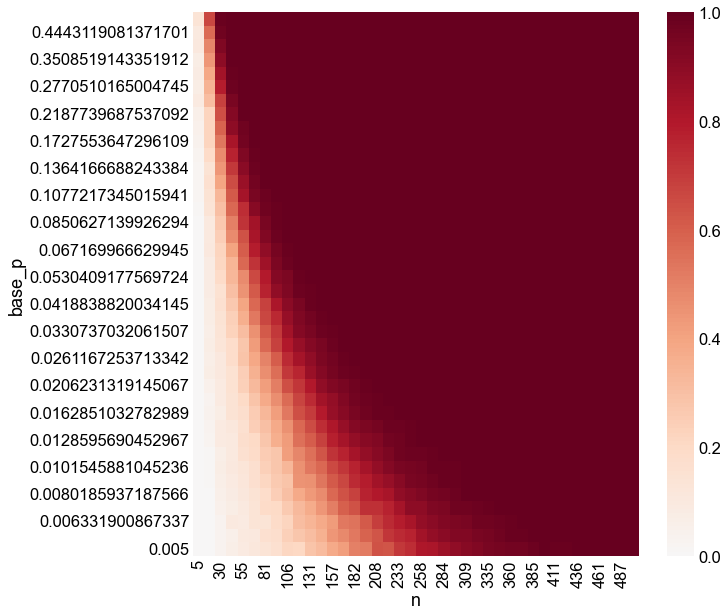

In [4]:


def compute_power(pvalues, alpha=0.05):
    return np.mean(pvalues < alpha)


power_results = (
    results.groupby(["n", "base_p"])["pvalue"]
    .apply(compute_power)
    .rename("power")
    .reset_index()
)

square_power = power_results.pivot(index="base_p", columns="n", values="power")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(square_power, ax=ax, cmap="RdBu_r", center=0, vmin=0, vmax=1)
ax.invert_yaxis()

<AxesSubplot:>

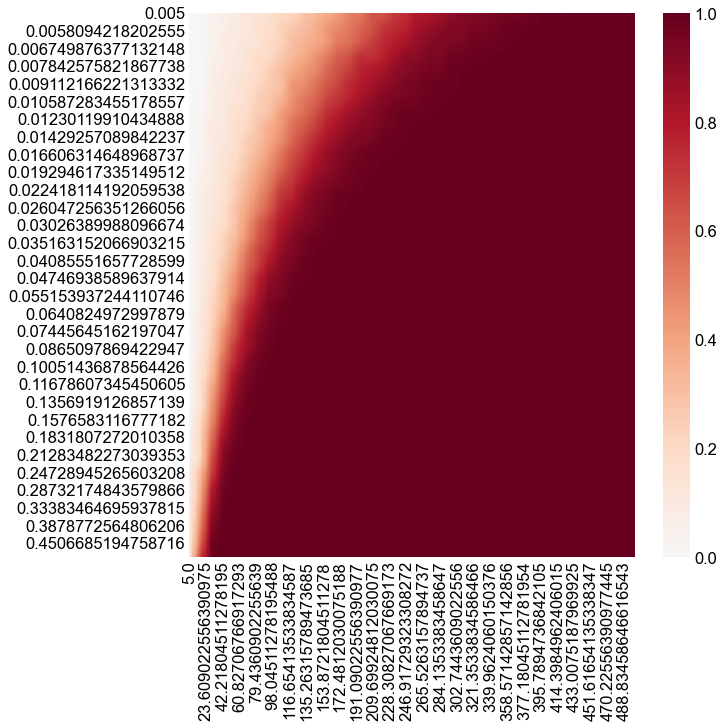

In [5]:

cols = square_power.columns.values
rows = square_power.index.values
values = square_power.values
interpolator = RegularGridInterpolator((rows, cols), values, bounds_error=True)

new_row_range = np.geomspace(0.005, 0.5, 400)
new_col_range = np.linspace(5, 500, 400)

rows, cols = np.meshgrid(new_row_range, new_col_range, indexing="ij")
zs = interpolator((rows, cols))

interp_df = pd.DataFrame(data=zs, index=new_row_range, columns=new_col_range)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(interp_df, cmap="RdBu_r", center=0, vmin=0, vmax=1)

In [6]:

set_theme(tick_size=5)

df = interp_df

levels = [0.25, 0.5, 0.9]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    df,
    cmap="RdBu_r",
    center=0,
    vmin=0,
    vmax=1,
    square=True,
    cbar_kws=dict(shrink=0.6, pad=0.1),
)
ax.invert_yaxis()
cs = plt.contour(zs, levels=levels, colors="black")
ax.clabel(cs, cs.levels, manual=[(0, 100), (100, 90), (463, 370)], colors="black")


iloc_to_x_value = interp1d(
    np.arange(0, df.shape[1]) + 0.5,
    df.columns.values,
    kind="linear",
    bounds_error=False,
    fill_value=(df.columns.values.min(), df.columns.values.max()),
)
x_value_to_iloc = interp1d(
    df.columns.values,
    np.arange(0, df.shape[1]) + 0.5,
    kind="linear",
    bounds_error=False,
    fill_value=(0.5, df.shape[1] - 0.5),
)

iloc_to_y_value = interp1d(
    np.arange(0, df.shape[0]) + 0.5,
    df.index.values,
    kind="linear",
    bounds_error=False,
    fill_value=(df.index.values.min(), df.index.values.max()),
)
y_value_to_iloc = interp1d(
    df.index.values,
    np.arange(0, df.shape[0]) + 0.5,
    kind="linear",
    bounds_error=False,
    fill_value=(-10, df.shape[0] + 10),  # not sure what these should be
)
ax.set(xticks=[], yticks=[], xlabel="", ylabel="")

xax2 = ax.secondary_xaxis(0, functions=(iloc_to_x_value, x_value_to_iloc))
xax2.set_xticks([5, 125, 250, 375, 500])


yax2 = ax.secondary_yaxis(0, functions=(iloc_to_y_value, y_value_to_iloc))
yax2.set_yscale("log")
yax2.set_yticks([0.005, 0.01, 0.05, 0.1, 0.5])
yax2.get_yaxis().set_major_formatter(ScalarFormatter())
yax2.set_ylim(0.005, 0.5)

cax = fig.get_axes()[1]
cax.set_title("Power @\n" + r"$\alpha=0.05$", pad=20)

yax2.set_ylabel("Base connection probability")
xax2.set_xlabel("Number of nodes")

gluefig("power_heatmap_contours", fig)

In [7]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:32.683195
Completed at 2023-03-08 12:47:09.276544
